<a href="https://colab.research.google.com/github/mohameddhameem/Learning-and-Planning-in-Intelligent-Systems/blob/main/Question_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
CS 711 - Assignment 2, Question 3
Dynamic Grid World Navigation: Tabular Q-Learning vs Approximate Q-Learning

Educational implementation using PyTorch for Approximate Q-Learning
Clean OOP design for better understanding of RL concepts
GPU-accelerated for Google Colab
"""

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import Tuple, List, Dict
import random

# GPU Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n{'='*80}")
print(f"DEVICE: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
print(f"{'='*80}\n")


# ============================================================================
# SECTION 1: ENVIRONMENT CONFIGURATION
# ============================================================================

class Config:
    """Centralized configuration with explicit assumptions"""

    # Grid Configuration
    GRID_SIZE = 4
    COORD_MIN = 0
    COORD_MAX = 3

    # Fixed Locations (0-indexed)
    # Assignment uses 1-indexed: (2,3)->R, (3,3)->M, (2,4)->M, (2,2)->Wall, (3,2)->Wall
    REPAIR_STATION = (1, 2)  # (2,3) in 1-indexed
    MONSTER_LOCATIONS = [(2, 2), (1, 3)]  # [(3,3), (2,4)] in 1-indexed
    WALL_POSITIONS = {(1, 1), (2, 1)}  # [(2,2), (3,2)] in 1-indexed
    PRIZE_CORNERS = [(0, 0), (0, 3), (3, 0), (3, 3)]  # 4 corners

    # State Space: (X, Y, Damaged, Prize_idx)
    # X, Y: 0-3; Damaged: 0-1; Prize_idx: 0-4
    NUM_STATES = 4 * 4 * 2 * 5  # 160 states
    NUM_ACTIONS = 4  # Up, Down, Left, Right

    # Actions
    ACTION_NAMES = {0: 'Up', 1: 'Down', 2: 'Left', 3: 'Right'}
    ACTION_DELTAS = {0: (0, -1), 1: (0, 1), 2: (-1, 0), 3: (1, 0)}

    # Rewards
    REWARD_PRIZE = 10.0
    REWARD_WALL = -1.0
    REWARD_DAMAGE_PER_STEP = -5.0
    REWARD_NORMAL = 0.0

    # Dynamics
    PRIZE_SPAWN_PROB = 0.1
    MONSTER_APPEAR_PROB = 0.2

    # Initial State (Agent at (1,2) in 1-indexed = (0,1) in 0-indexed)
    INITIAL_X = 0
    INITIAL_Y = 1
    INITIAL_DAMAGED = False
    INITIAL_PRIZE_IDX = 1  # Prize at corner 1

    # Episode Configuration
    MAX_STEPS = 1000
    GOAL_REWARD = 50.0

    # Training Configuration
    NUM_EPISODES = 2000
    NUM_SEEDS = 3

    # Q-Learning Hyperparameters
    ALPHA = 0.1  # Learning rate
    GAMMA = 0.9  # Discount factor
    EPSILON_INITIAL = 1.0
    EPSILON_FINAL = 0.01
    EPSILON_DECAY_EPISODES = 1000

    # Approximate Q-Learning
    NUM_FEATURES = 4
    MAX_MANHATTAN_DISTANCE = 6.0  # Max distance on 4x4 grid


# ============================================================================
# SECTION 2: STATE UTILITIES
# ============================================================================

class StateEncoder:
    """Handles state encoding/decoding"""

    @staticmethod
    def encode(x: int, y: int, damaged: bool, prize_idx: int) -> int:
        """
        Convert state components to integer state ID
        State ID = x * (4*2*5) + y * (2*5) + damaged * 5 + prize_idx
        """
        damaged_int = 1 if damaged else 0
        state_id = (x * 4 * 2 * 5) + (y * 2 * 5) + (damaged_int * 5) + prize_idx
        return state_id

    @staticmethod
    def decode(state_id: int) -> Tuple[int, int, bool, int]:
        """Decode state ID back to components"""
        x = state_id // (4 * 2 * 5)
        remainder = state_id % (4 * 2 * 5)
        y = remainder // (2 * 5)
        remainder = remainder % (2 * 5)
        damaged = remainder // 5
        prize_idx = remainder % 5
        return x, y, bool(damaged), prize_idx


# ============================================================================
# SECTION 3: GRID WORLD ENVIRONMENT
# ============================================================================

class GridWorldEnvironment:
    """
    Complete MDP simulator for dynamic grid world
    Implements all state transitions and reward logic
    """

    def __init__(self, seed: int = 42):
        self.config = Config()
        self.encoder = StateEncoder()
        self.rng = np.random.RandomState(seed)
        self.reset()

    def reset(self) -> int:
        """Reset to initial state"""
        self.x = self.config.INITIAL_X
        self.y = self.config.INITIAL_Y
        self.damaged = self.config.INITIAL_DAMAGED
        self.prize_idx = self.config.INITIAL_PRIZE_IDX
        self.current_monsters = set()
        self.cumulative_reward = 0.0
        self.step_count = 0
        return self.get_state()

    def get_state(self) -> int:
        """Return current state as encoded integer"""
        return self.encoder.encode(self.x, self.y, self.damaged, self.prize_idx)

    def get_state_components(self) -> Tuple[int, int, bool, int]:
        """Return state components for debugging"""
        return self.x, self.y, self.damaged, self.prize_idx

    def _apply_action(self, x: int, y: int, action: int) -> Tuple[int, int, bool]:
        """Apply action and return (new_x, new_y, wall_collision)"""
        dx, dy = self.config.ACTION_DELTAS[action]
        new_x, new_y = x + dx, y + dy

        # Check boundaries
        if not (self.config.COORD_MIN <= new_x <= self.config.COORD_MAX and
                self.config.COORD_MIN <= new_y <= self.config.COORD_MAX):
            return x, y, True

        # Check inner walls
        if (new_x, new_y) in self.config.WALL_POSITIONS:
            return x, y, True

        return new_x, new_y, False

    def step(self, action: int) -> Tuple[int, float, bool]:
        """
        Execute one environment step

        Returns:
            next_state: encoded state integer
            reward: immediate reward
            done: episode termination flag
        """
        reward = 0.0

        # STEP 1: Apply movement
        new_x, new_y, wall_hit = self._apply_action(self.x, self.y, action)

        if wall_hit:
            reward += self.config.REWARD_WALL
        else:
            self.x, self.y = new_x, new_y

        # STEP 2: Check prize collection
        if self.prize_idx > 0:
            prize_x, prize_y = self.config.PRIZE_CORNERS[self.prize_idx - 1]
            if (self.x, self.y) == (prize_x, prize_y):
                reward += self.config.REWARD_PRIZE
                self.prize_idx = 0

        # STEP 3: Check repair station
        if (self.x, self.y) == self.config.REPAIR_STATION and self.damaged:
            self.damaged = False

        # STEP 4: Update monster locations (stochastic)
        self.current_monsters.clear()
        for monster_loc in self.config.MONSTER_LOCATIONS:
            if self.rng.random() < self.config.MONSTER_APPEAR_PROB:
                self.current_monsters.add(monster_loc)

        # STEP 5: Apply damage from monster
        if (self.x, self.y) in self.current_monsters and not self.damaged:
            self.damaged = True

        # STEP 6: Damage penalty
        if self.damaged:
            reward += self.config.REWARD_DAMAGE_PER_STEP

        # STEP 7: Prize respawn (stochastic)
        if self.prize_idx == 0:
            if self.rng.random() < self.config.PRIZE_SPAWN_PROB:
                self.prize_idx = self.rng.randint(1, 5)

        # STEP 8: Check termination
        self.cumulative_reward += reward
        self.step_count += 1

        done = (self.step_count >= self.config.MAX_STEPS or
                self.cumulative_reward >= self.config.GOAL_REWARD)

        return self.get_state(), reward, done

    def validate(self, num_trajectories: int = 10) -> Dict:
        """Validate environment with random trajectories"""
        print("="*80)
        print("ENVIRONMENT VALIDATION")
        print("="*80)

        results = {'completed': 0, 'errors': []}

        for traj in range(num_trajectories):
            state = self.reset()
            for step in range(50):
                action = self.rng.randint(0, self.config.NUM_ACTIONS)

                try:
                    next_state, reward, done = self.step(action)
                    x, y, damaged, prize_idx = self.encoder.decode(next_state)

                    # Validation checks
                    assert 0 <= x <= 3, f"X out of bounds: {x}"
                    assert 0 <= y <= 3, f"Y out of bounds: {y}"
                    assert 0 <= prize_idx <= 4, f"Prize_idx invalid: {prize_idx}"

                    if done:
                        break

                except Exception as e:
                    results['errors'].append(f"Traj {traj}, Step {step}: {e}")
                    break

            results['completed'] += 1

        if results['errors']:
            print(f"FAILED: {len(results['errors'])} errors")
            for err in results['errors'][:5]:
                print(f"  - {err}")
        else:
            print(f"PASSED: {results['completed']} trajectories completed")
        print("="*80)

        return results


# ============================================================================
# SECTION 4: TABULAR Q-LEARNING
# ============================================================================

class TabularQLearner:
    """
    Tabular Q-Learning Agent
    Maintains Q(s,a) table for all 160 states × 4 actions

    Q-Learning Update:
    Q(s,a) ← Q(s,a) + α[r + γ·max_a' Q(s',a') - Q(s,a)]
    """

    def __init__(self, config: Config, seed: int = 42):
        self.config = config
        self.seed = seed
        np.random.seed(seed)
        random.seed(seed)

        # Initialize Q-table to zeros
        self.Q = defaultdict(lambda: 0.0)

        # Learning parameters
        self.alpha = config.ALPHA
        self.gamma = config.GAMMA
        self.epsilon = config.EPSILON_INITIAL

        # Tracking
        self.episode = 0
        self.training_history = []

    def _update_epsilon(self):
        """Linear epsilon decay"""
        if self.episode < self.config.EPSILON_DECAY_EPISODES:
            decay = (self.config.EPSILON_INITIAL - self.config.EPSILON_FINAL)
            decay_rate = decay / self.config.EPSILON_DECAY_EPISODES
            self.epsilon = self.config.EPSILON_INITIAL - (decay_rate * self.episode)
        else:
            self.epsilon = self.config.EPSILON_FINAL

    def select_action(self, state: int, greedy: bool = False) -> int:
        """ε-greedy action selection"""
        if not greedy and np.random.random() < self.epsilon:
            return np.random.randint(0, self.config.NUM_ACTIONS)
        else:
            # Greedy: argmax_a Q(s,a)
            q_values = [self.Q[(state, a)] for a in range(self.config.NUM_ACTIONS)]
            return int(np.argmax(q_values))

    def train_episode(self, env: GridWorldEnvironment) -> float:
        """
        Run one training episode with Q-learning updates

        Q-Learning Update Rule:
        Q(s,a) ← Q(s,a) + α[r + γ·max_a' Q(s',a') - Q(s,a)]
        """
        state = env.reset()
        cumulative_reward = 0.0

        while True:
            # Select action
            action = self.select_action(state)

            # Execute action
            next_state, reward, done = env.step(action)
            cumulative_reward += reward

            # Q-Learning Update
            # Calculate max Q-value for next state
            max_q_next = max([self.Q[(next_state, a)]
                             for a in range(self.config.NUM_ACTIONS)])

            # TD error: r + γ·max_a' Q(s',a') - Q(s,a)
            td_error = reward + self.gamma * max_q_next - self.Q[(state, action)]

            # Update Q-value
            self.Q[(state, action)] += self.alpha * td_error

            if done:
                break

            state = next_state

        # Update epsilon
        self._update_epsilon()
        self.episode += 1
        self.training_history.append(cumulative_reward)

        return cumulative_reward

    def train(self, env: GridWorldEnvironment, num_episodes: int) -> List[float]:
        """Train for multiple episodes"""
        print(f"\n[Tabular Q-Learning | Seed {self.seed}] Training...")

        for ep in range(num_episodes):
            reward = self.train_episode(env)

            if (ep + 1) % 500 == 0:
                avg_reward = np.mean(self.training_history[-100:])
                print(f"  Episode {ep+1}/{num_episodes} | "
                      f"Avg Reward (last 100): {avg_reward:.2f} | "
                      f"ε: {self.epsilon:.3f}")

        return self.training_history

    def evaluate(self, env: GridWorldEnvironment, num_episodes: int = 100) -> List[float]:
        """Evaluate learned policy (greedy, no exploration)"""
        eval_rewards = []

        for _ in range(num_episodes):
            state = env.reset()
            cumulative_reward = 0.0

            while True:
                action = self.select_action(state, greedy=True)
                next_state, reward, done = env.step(action)
                cumulative_reward += reward

                if done:
                    break
                state = next_state

            eval_rewards.append(cumulative_reward)

        return eval_rewards


# ============================================================================
# SECTION 5: APPROXIMATE Q-LEARNING
# ============================================================================

class FeatureExtractor:
    """
    Extract hand-crafted features for Approximate Q-Learning
    CRITICAL: Features must be action-dependent f(s,a), not just f(s)
    """

    def __init__(self, config: Config):
        self.config = config
        self.encoder = StateEncoder()

    def _get_next_position(self, x: int, y: int, action: int) -> Tuple[int, int]:
        """Get resulting position after taking action (considering walls)"""
        dx, dy = self.config.ACTION_DELTAS[action]
        new_x, new_y = x + dx, y + dy

        # Check boundaries
        if not (self.config.COORD_MIN <= new_x <= self.config.COORD_MAX and
                self.config.COORD_MIN <= new_y <= self.config.COORD_MAX):
            return x, y  # Stay in place

        # Check inner walls
        if (new_x, new_y) in self.config.WALL_POSITIONS:
            return x, y  # Stay in place

        return new_x, new_y

    def extract(self, state: int, action: int) -> np.ndarray:
        """
        Extract action-dependent features f(s,a)

        Features consider the RESULT of taking action a from state s:
        f1: Distance to prize AFTER taking action a
        f2: Distance to repair station AFTER taking action a
        f3: Is damaged AND not moving to repair? (action-dependent)
        f4: Will action lead to monster location? (action-dependent)
        """
        x, y, damaged, prize_idx = self.encoder.decode(state)
        features = np.zeros(self.config.NUM_FEATURES, dtype=np.float32)

        # Get position after taking action
        next_x, next_y = self._get_next_position(x, y, action)

        # Feature 1: Distance to prize AFTER taking action
        if prize_idx > 0:
            prize_x, prize_y = self.config.PRIZE_CORNERS[prize_idx - 1]
            dist = abs(next_x - prize_x) + abs(next_y - prize_y)
        else:
            # Prize collected, find closest corner from next position
            dist = min([abs(next_x - cx) + abs(next_y - cy)
                       for cx, cy in self.config.PRIZE_CORNERS])

        features[0] = max(0.0, 1.0 - dist / self.config.MAX_MANHATTAN_DISTANCE)

        # Feature 2: Distance to repair station AFTER taking action
        rx, ry = self.config.REPAIR_STATION
        dist_repair = abs(next_x - rx) + abs(next_y - ry)
        features[1] = max(0.0, 1.0 - dist_repair / self.config.MAX_MANHATTAN_DISTANCE)

        # Feature 3: Is damaged AND action doesn't lead to repair?
        # This is action-dependent: encourages damaged agent to go to repair
        will_reach_repair = ((next_x, next_y) == self.config.REPAIR_STATION)
        features[2] = 1.0 if (damaged and not will_reach_repair) else 0.0

        # Feature 4: Will action lead to a monster location?
        # Action-dependent danger indicator
        min_dist_monster = min([abs(next_x - mx) + abs(next_y - my)
                               for mx, my in self.config.MONSTER_LOCATIONS])
        features[3] = 1.0 if min_dist_monster == 0 else 0.0

        return features


class ApproximateQLearner:
    """
    Approximate Q-Learning with Linear Function Approximation

    Q(s,a) = w^T · f(s,a)  [CRITICAL: action-dependent features]

    Weight Update:
    w ← w + α[r + γ·max_a' Q(s',a') - Q(s,a)]·f(s,a)

    The key difference from the initial implementation:
    - Features f(s,a) depend on BOTH state AND action
    - Different actions produce different Q-values
    - Agent can learn a meaningful policy by distinguishing actions

    GPU-Accelerated: Weights and computations on GPU when available
    """

    def __init__(self, config: Config, seed: int = 42):
        self.config = config
        self.seed = seed
        np.random.seed(seed)
        random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)

        # Initialize weights on GPU
        self.weights = torch.zeros(config.NUM_FEATURES, dtype=torch.float32, device=device)

        # Feature extractor
        self.feature_extractor = FeatureExtractor(config)

        # Learning parameters
        self.alpha = config.ALPHA
        self.gamma = config.GAMMA
        self.epsilon = config.EPSILON_INITIAL

        # Tracking
        self.episode = 0
        self.training_history = []

    def _update_epsilon(self):
        """Linear epsilon decay (same as Tabular)"""
        if self.episode < self.config.EPSILON_DECAY_EPISODES:
            decay = (self.config.EPSILON_INITIAL - self.config.EPSILON_FINAL)
            decay_rate = decay / self.config.EPSILON_DECAY_EPISODES
            self.epsilon = self.config.EPSILON_INITIAL - (decay_rate * self.episode)
        else:
            self.epsilon = self.config.EPSILON_FINAL

    def compute_q_value(self, state: int, action: int) -> float:
        """
        Compute Q(s,a) using linear function approximation
        Q(s,a) = w^T · f(s,a)

        CRITICAL: Features are action-dependent f(s,a)
        GPU-accelerated dot product
        """
        features = self.feature_extractor.extract(state, action)
        features_tensor = torch.from_numpy(features).to(device)
        q_value = torch.dot(self.weights, features_tensor).item()
        return q_value

    def compute_q_values_batch(self, state: int) -> torch.Tensor:
        """
        Compute Q(s,a) for all actions at once (GPU-accelerated)
        Returns tensor of shape (NUM_ACTIONS,)
        """
        # Extract features for all actions
        features_list = [self.feature_extractor.extract(state, a)
                        for a in range(self.config.NUM_ACTIONS)]
        features_batch = np.stack(features_list)  # Shape: (NUM_ACTIONS, NUM_FEATURES)
        features_tensor = torch.from_numpy(features_batch).to(device)

        # Batch matrix-vector multiplication: (4, 4) @ (4,) -> (4,)
        q_values = features_tensor @ self.weights
        return q_values

    def select_action(self, state: int, greedy: bool = False) -> int:
        """
        ε-greedy action selection with proper Q(s,a) comparison

        CRITICAL: Now that features are action-dependent, different actions
        have different Q-values, enabling meaningful policy learning

        Uses GPU-accelerated batch Q-value computation
        """
        if not greedy and np.random.random() < self.epsilon:
            return np.random.randint(0, self.config.NUM_ACTIONS)
        else:
            # Compute Q-values for all actions in parallel on GPU
            with torch.no_grad():
                q_values = self.compute_q_values_batch(state)

            # Greedy: argmax_a Q(s,a)
            # Use torch.argmax for robust handling
            best_action = torch.argmax(q_values).item()

            # Alternative: if you want tie-breaking among equal best actions
            # Use a small tolerance for floating-point comparison
            max_q = q_values.max().item()
            tolerance = 1e-6
            best_actions_mask = (q_values >= max_q - tolerance)
            best_actions = best_actions_mask.nonzero(as_tuple=True)[0]

            if len(best_actions) > 0:
                # Random choice among best actions (tie-breaking)
                idx = np.random.randint(len(best_actions))
                return best_actions[idx].item()
            else:
                # Fallback: return argmax
                return best_action

    def train_episode(self, env: GridWorldEnvironment) -> float:
        """
        Run one training episode with weight updates

        Approximate Q-Learning Update:
        w ← w + α·[r + γ·max_a' Q(s',a') - Q(s,a)]·f(s,a)

        CRITICAL: Features f(s,a) must be computed for the specific
        state-action pair (s,a) that was taken

        GPU-accelerated weight updates
        """
        state = env.reset()
        cumulative_reward = 0.0

        while True:
            # Select action using ε-greedy
            action = self.select_action(state)

            # Execute action
            next_state, reward, done = env.step(action)
            cumulative_reward += reward

            # Compute Q(s,a) for the action taken
            q_current = self.compute_q_value(state, action)

            # Compute max_a' Q(s',a') for next state (GPU-accelerated)
            with torch.no_grad():
                q_next_values = self.compute_q_values_batch(next_state)
                q_next_max = q_next_values.max().item()

            # TD error: r + γ·max_a' Q(s',a') - Q(s,a)
            td_error = reward + self.gamma * q_next_max - q_current

            # Extract features for the specific (s,a) pair
            features = self.feature_extractor.extract(state, action)
            features_tensor = torch.from_numpy(features).to(device)

            # Weight update: w ← w + α·td_error·f(s,a)
            # GPU-accelerated in-place update
            self.weights.add_(features_tensor, alpha=self.alpha * td_error)

            if done:
                break

            state = next_state

        # Update epsilon
        self._update_epsilon()
        self.episode += 1
        self.training_history.append(cumulative_reward)

        return cumulative_reward

    def train(self, env: GridWorldEnvironment, num_episodes: int) -> List[float]:
        """Train for multiple episodes"""
        print(f"\n[Approximate Q-Learning | Seed {self.seed} | Device: {device}] Training...")

        for ep in range(num_episodes):
            reward = self.train_episode(env)

            if (ep + 1) % 500 == 0:
                avg_reward = np.mean(self.training_history[-100:])
                print(f"  Episode {ep+1}/{num_episodes} | "
                      f"Avg Reward (last 100): {avg_reward:.2f} | "
                      f"ε: {self.epsilon:.3f}")

        return self.training_history

    def evaluate(self, env: GridWorldEnvironment, num_episodes: int = 100) -> List[float]:
        """Evaluate learned policy"""
        eval_rewards = []

        for _ in range(num_episodes):
            state = env.reset()
            cumulative_reward = 0.0

            while True:
                action = self.select_action(state, greedy=True)
                next_state, reward, done = env.step(action)
                cumulative_reward += reward

                if done:
                    break
                state = next_state

            eval_rewards.append(cumulative_reward)

        return eval_rewards

    def get_weights_cpu(self) -> np.ndarray:
        """Get weights as numpy array on CPU (useful for analysis)"""
        return self.weights.cpu().numpy()


# ============================================================================
# SECTION 6: EXPERIMENT RUNNER & VISUALIZATION
# ============================================================================

class ExperimentRunner:
    """Run complete experiments with multiple seeds"""

    def __init__(self, config: Config):
        self.config = config

    def run_single_seed(self, seed: int) -> Dict:
        """Run experiment with single seed"""
        print(f"\n{'='*80}")
        print(f"RUNNING EXPERIMENT WITH SEED {seed}")
        print(f"{'='*80}")

        # Create environment
        env = GridWorldEnvironment(seed=seed)

        # Tabular Q-Learning
        tabular_agent = TabularQLearner(self.config, seed=seed)
        tabular_train = tabular_agent.train(env, self.config.NUM_EPISODES)
        tabular_eval = tabular_agent.evaluate(env, num_episodes=100)

        # Approximate Q-Learning
        approx_agent = ApproximateQLearner(self.config, seed=seed)
        approx_train = approx_agent.train(env, self.config.NUM_EPISODES)
        approx_eval = approx_agent.evaluate(env, num_episodes=100)

        return {
            'tabular_train': tabular_train,
            'tabular_eval': tabular_eval,
            'approx_train': approx_train,
            'approx_eval': approx_eval,
            'approx_agent': approx_agent  # Keep for weight analysis
        }

    def run_multiple_seeds(self, seeds: List[int]) -> Dict:
        """Run experiments across multiple seeds"""
        all_results = []

        for seed in seeds:
            results = self.run_single_seed(seed)
            all_results.append(results)

        return self.aggregate_results(all_results)

    def aggregate_results(self, all_results: List[Dict]) -> Dict:
        """Aggregate results across seeds"""
        tabular_trains = [r['tabular_train'] for r in all_results]
        tabular_evals = [r['tabular_eval'] for r in all_results]
        approx_trains = [r['approx_train'] for r in all_results]
        approx_evals = [r['approx_eval'] for r in all_results]

        return {
            'tabular': {
                'train': np.array(tabular_trains),
                'eval_mean': np.mean([np.mean(e) for e in tabular_evals]),
                'eval_std': np.std([np.mean(e) for e in tabular_evals])
            },
            'approx': {
                'train': np.array(approx_trains),
                'eval_mean': np.mean([np.mean(e) for e in approx_evals]),
                'eval_std': np.std([np.mean(e) for e in approx_evals])
            }
        }


class Visualizer:
    """Visualization utilities"""

    @staticmethod
    def plot_results(aggregated: Dict, save_path: str = 'results.png'):
        """Plot training curves and comparison"""
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # Tabular Q-Learning
        ax = axes[0]
        tabular_data = aggregated['tabular']['train']
        for i, train_curve in enumerate(tabular_data):
            ax.plot(train_curve, alpha=0.4, label=f'Seed {i}')

        mean_curve = np.mean(tabular_data, axis=0)
        ax.plot(mean_curve, 'b-', linewidth=2.5, label='Mean')
        ax.set_xlabel('Episode', fontsize=11)
        ax.set_ylabel('Cumulative Reward', fontsize=11)
        ax.set_title('Tabular Q-Learning', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(alpha=0.3)

        # Approximate Q-Learning
        ax = axes[1]
        approx_data = aggregated['approx']['train']
        for i, train_curve in enumerate(approx_data):
            ax.plot(train_curve, alpha=0.4, label=f'Seed {i}')

        mean_curve = np.mean(approx_data, axis=0)
        ax.plot(mean_curve, 'r-', linewidth=2.5, label='Mean')
        ax.set_xlabel('Episode', fontsize=11)
        ax.set_ylabel('Cumulative Reward', fontsize=11)
        ax.set_title('Approximate Q-Learning', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(alpha=0.3)

        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"\n[PLOT] Saved to {save_path}")
        plt.show()  # Display in Colab
        plt.close()

    @staticmethod
    def print_summary(aggregated: Dict):
        """Print summary statistics"""
        print("\n" + "="*80)
        print("EVALUATION RESULTS SUMMARY")
        print("="*80)

        print("\nTabular Q-Learning:")
        print(f"  Mean Eval Reward: {aggregated['tabular']['eval_mean']:.2f} ± "
              f"{aggregated['tabular']['eval_std']:.2f}")

        print("\nApproximate Q-Learning:")
        print(f"  Mean Eval Reward: {aggregated['approx']['eval_mean']:.2f} ± "
              f"{aggregated['approx']['eval_std']:.2f}")

        print("\n" + "="*80)

    @staticmethod
    def plot_comparison(aggregated: Dict, save_path: str = 'comparison.png'):
        """Plot direct comparison of both methods"""
        fig, ax = plt.subplots(figsize=(10, 6))

        # Compute mean and std
        tabular_mean = np.mean(aggregated['tabular']['train'], axis=0)
        tabular_std = np.std(aggregated['tabular']['train'], axis=0)
        approx_mean = np.mean(aggregated['approx']['train'], axis=0)
        approx_std = np.std(aggregated['approx']['train'], axis=0)

        episodes = np.arange(len(tabular_mean))

        # Plot with confidence intervals
        ax.plot(episodes, tabular_mean, 'b-', linewidth=2, label='Tabular Q-Learning')
        ax.fill_between(episodes, tabular_mean - tabular_std, tabular_mean + tabular_std,
                        alpha=0.2, color='blue')

        ax.plot(episodes, approx_mean, 'r-', linewidth=2, label='Approximate Q-Learning')
        ax.fill_between(episodes, approx_mean - approx_std, approx_mean + approx_std,
                        alpha=0.2, color='red')

        ax.set_xlabel('Episode', fontsize=12)
        ax.set_ylabel('Cumulative Reward', fontsize=12)
        ax.set_title('Comparison: Tabular vs Approximate Q-Learning',
                    fontsize=13, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(alpha=0.3)

        plt.tight_layout()
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"[PLOT] Saved to {save_path}")
        plt.show()  # Display in Colab
        plt.close()

    @staticmethod
    def plot_weights_evolution(approx_agent: ApproximateQLearner):
        """Plot learned feature weights (Approximate Q-Learning)"""
        weights = approx_agent.get_weights_cpu()

        fig, ax = plt.subplots(figsize=(8, 5))
        feature_names = ['f1: Dist to Prize', 'f2: Dist to Repair',
                        'f3: Damaged', 'f4: Near Monster']

        bars = ax.bar(feature_names, weights, color=['#2ecc71', '#3498db', '#e74c3c', '#f39c12'])
        ax.set_ylabel('Weight Value', fontsize=11)
        ax.set_title('Learned Feature Weights (Approximate Q-Learning)',
                    fontsize=12, fontweight='bold')
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax.grid(axis='y', alpha=0.3)

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom' if height > 0 else 'top')

        plt.tight_layout()
        plt.savefig('feature_weights.png', dpi=150, bbox_inches='tight')
        print(f"[PLOT] Saved to feature_weights.png")
        plt.show()
        plt.close()


# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Main execution function"""
    print("\n" + "="*80)
    print("CS 711 - ASSIGNMENT 2, QUESTION 3")
    print("Dynamic Grid World: Tabular vs Approximate Q-Learning")
    print("="*80)

    # Configuration
    config = Config()

    # Phase 1: Validate environment
    print("\n[PHASE 1] Environment Validation")
    env = GridWorldEnvironment(seed=42)
    env.validate(num_trajectories=10)

    # Phase 2-3: Training and Evaluation
    print("\n[PHASE 2-3] Training and Evaluation")
    runner = ExperimentRunner(config)
    seeds = [42, 123, 456]
    aggregated = runner.run_multiple_seeds(seeds)

    # Phase 4: Results
    print("\n[PHASE 4] Results Analysis")
    Visualizer.print_summary(aggregated)
    Visualizer.plot_results(aggregated)
    Visualizer.plot_comparison(aggregated)

    # Memory cleanup for Colab
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"\n[GPU] Memory cleared")

    print("\n" + "="*80)
    print("EXPERIMENT COMPLETE")
    print("="*80)


DEVICE: cuda
GPU: Tesla T4
CUDA Version: 12.6




CS 711 - ASSIGNMENT 2, QUESTION 3
Dynamic Grid World: Tabular vs Approximate Q-Learning

[PHASE 1] Environment Validation
ENVIRONMENT VALIDATION
PASSED: 10 trajectories completed

[PHASE 2-3] Training and Evaluation

RUNNING EXPERIMENT WITH SEED 42

[Tabular Q-Learning | Seed 42] Training...
  Episode 500/2000 | Avg Reward (last 100): 53.44 | ε: 0.506
  Episode 1000/2000 | Avg Reward (last 100): 54.62 | ε: 0.011
  Episode 1500/2000 | Avg Reward (last 100): 52.78 | ε: 0.010
  Episode 2000/2000 | Avg Reward (last 100): 54.36 | ε: 0.010

[Approximate Q-Learning | Seed 42 | Device: cuda] Training...
  Episode 500/2000 | Avg Reward (last 100): -1658.17 | ε: 0.506
  Episode 1000/2000 | Avg Reward (last 100): -944.21 | ε: 0.011
  Episode 1500/2000 | Avg Reward (last 100): -978.09 | ε: 0.010
  Episode 2000/2000 | Avg Reward (last 100): -979.38 | ε: 0.010

RUNNING EXPERIMENT WITH SEED 123

[Tabular Q-Learning | Seed 123] Training...
  Episode 500/2000 | Avg Reward (last 100): 49.89 | ε: 0.506


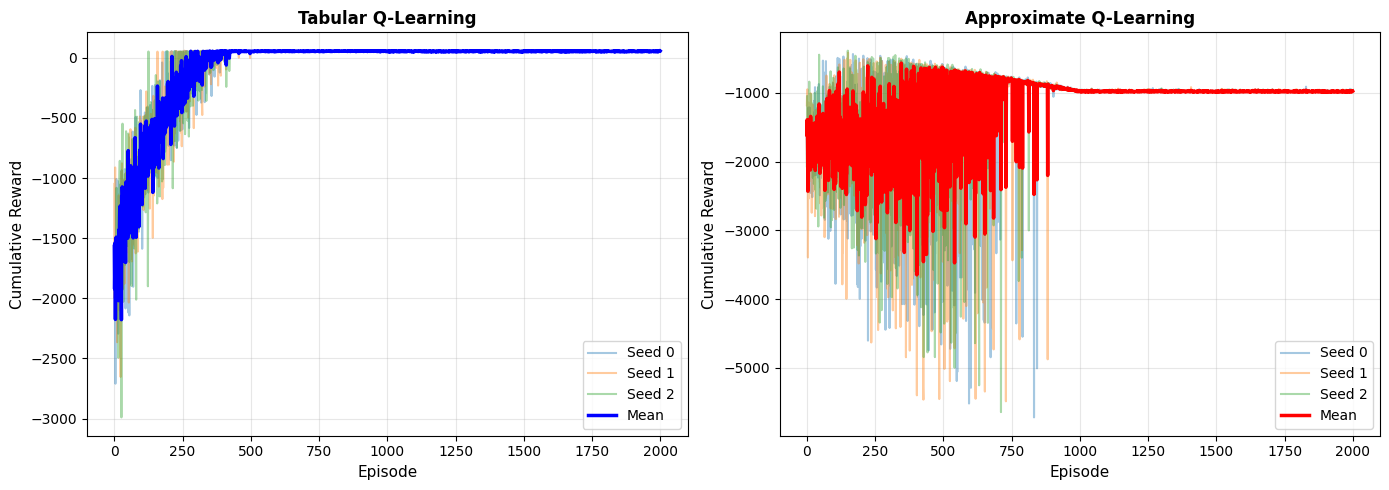

[PLOT] Saved to comparison.png


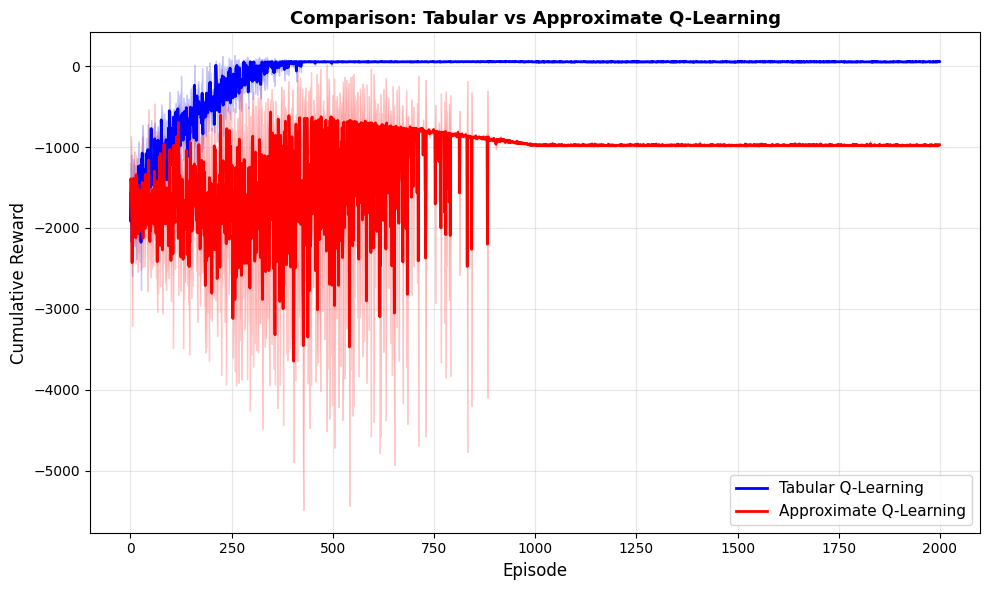


[BONUS] Feature Weight Analysis

RUNNING EXPERIMENT WITH SEED 456

[Tabular Q-Learning | Seed 456] Training...
  Episode 500/2000 | Avg Reward (last 100): 45.82 | ε: 0.506
  Episode 1000/2000 | Avg Reward (last 100): 55.40 | ε: 0.011
  Episode 1500/2000 | Avg Reward (last 100): 52.48 | ε: 0.010
  Episode 2000/2000 | Avg Reward (last 100): 52.23 | ε: 0.010

[Approximate Q-Learning | Seed 456 | Device: cuda] Training...
  Episode 500/2000 | Avg Reward (last 100): -1575.51 | ε: 0.506
  Episode 1000/2000 | Avg Reward (last 100): -942.50 | ε: 0.011
  Episode 1500/2000 | Avg Reward (last 100): -978.93 | ε: 0.010
  Episode 2000/2000 | Avg Reward (last 100): -980.31 | ε: 0.010
[PLOT] Saved to feature_weights.png


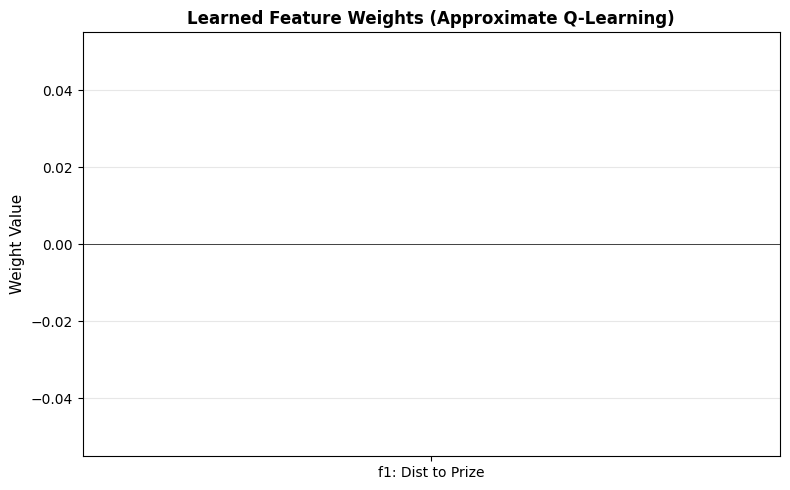


[GPU] Memory cleared

EXPERIMENT COMPLETE


In [ ]:
main()

In [ ]:
import sys
!{sys.executable} -m pip install -q stable-baselines3 gymnasium

In [ ]:
import gymnasium as gym
from gymnasium import spaces

class SB3GridWorldEnv(gym.Env):
    metadata = {'render_modes': ['human'], 'render_fps': 30}

    def __init__(self, config: Config, seed: int = 42):
        super(SB3GridWorldEnv, self).__init__()
        self.config = config
        self.grid_env = GridWorldEnvironment(seed=seed)
        self.encoder = StateEncoder()

        # Define action and observation space
        # Actions: 0: Up, 1: Down, 2: Left, 3: Right
        self.action_space = spaces.Discrete(self.config.NUM_ACTIONS)

        # Observation space: single integer representing the encoded state
        # Max state ID is NUM_STATES - 1
        self.observation_space = spaces.Discrete(self.config.NUM_STATES)

        self.current_state = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_state = self.grid_env.reset()
        info = {}
        return self.current_state, info

    def step(self, action):
        next_state_int, reward, done = self.grid_env.step(action)
        self.current_state = next_state_int
        truncated = False # SB3 typically separates 'done' into 'terminated' and 'truncated'
                          # For this env, 'done' covers both goals and max steps, so we map to 'terminated'
        info = {}
        return next_state_int, reward, done, truncated, info

    def render(self):
        # Optional: Implement rendering if you want to visualize the environment
        # For this text-based/grid world, we might just print state components
        x, y, damaged, prize_idx = self.encoder.decode(self.current_state)
        print(f"Agent: ({x},{y}), Damaged: {damaged}, Prize: {prize_idx}")

    def close(self):
        # No specific resources to close for this environment
        pass


In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

def run_sb3_experiment(config: Config, seed: int):
    print(f"\n{'='*80}")
    print(f"RUNNING SB3 EXPERIMENT WITH SEED {seed}")
    print(f"{'='*80}")

    # Create the SB3 compatible environment
    # Use make_vec_env for multiprocessing, even for a single environment, as it's standard practice with SB3
    sb3_env = make_vec_env(lambda: SB3GridWorldEnv(config, seed=seed), n_envs=1, seed=seed)

    # Initialize and train the PPO agent
    # Policy: MlpPolicy (Multi-layer Perceptron Policy) for discrete action spaces
    # verbose=1 for training progress
    model = PPO("MlpPolicy", sb3_env, verbose=0, seed=seed,
                gamma=config.GAMMA, learning_rate=config.ALPHA, # Use existing config for consistency
                n_steps=2048, # Number of steps to run for each environment per update
                batch_size=64, # Minibatch size
                ent_coef=0.01, # Entropy coefficient for exploration
               )

    total_timesteps = config.NUM_EPISODES * config.MAX_STEPS # A rough estimate, SB3 uses timesteps
    print(f"  Training SB3 PPO for {total_timesteps} timesteps...")
    model.learn(total_timesteps=total_timesteps, progress_bar=True)

    print("  Evaluation SB3 agent...")
    eval_rewards = []
    for _ in range(100):
        obs, info = sb3_env.reset()
        cumulative_reward = 0.0
        done = False
        truncated = False
        while not done and not truncated:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = sb3_env.step(action)
            cumulative_reward += reward[0] # reward is a list from vec_env
        eval_rewards.append(cumulative_reward)

    sb3_env.close()
    return eval_rewards

def main_sb3_integration():
    config = Config()
    seeds = [42, 123, 456]
    all_sb3_eval_rewards = []

    for seed in seeds:
        eval_rewards = run_sb3_experiment(config, seed)
        all_sb3_eval_rewards.extend(eval_rewards)

    mean_eval_reward = np.mean(all_sb3_eval_rewards)
    std_eval_reward = np.std(all_sb3_eval_rewards)

    print(f"\n{'='*80}")
    print(f"SB3 PPO Evaluation Summary (across {len(seeds)} seeds):")
    print(f"  Mean Eval Reward: {mean_eval_reward:.2f} ± {std_eval_reward:.2f}")
    print(f"{'='*80}")

# Call the main function to run the SB3 integration
main_sb3_integration()


 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2,000,875/2,000,000  [ 1:14:43 < 0:00:00 , 487 it/s ]

  Evaluation SB3 agent...


ValueError: not enough values to unpack (expected 2, got 1)